# Attempt to optimally represent an Input Set through available other Sets

## Library Imports

In [23]:
import math
import numpy as np
from matplotlib import pyplot as plt
from numpy import random as rnd
import warnings,datetime,os,calendar,csv,time
import pickle,h5py,json

import tensorflow as tf
import pandas as pd
import seaborn as sns

from keras.models import Model,Sequential
from keras.layers import Dense,LSTM,Conv2D,Dropout,BatchNormalization,Input,Concatenate,Add,Activation,MaxPooling2D,AveragePooling2D
import keras.backend as K

from sklearn import preprocessing as pp

from sklearn.cluster import KMeans,MeanShift
from sklearn.dummy import DummyClassifier,DummyRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier,AdaBoostRegressor,RandomForestClassifier,RandomForestRegressor
from sklearn.linear_model import BayesianRidge,Lasso,LinearRegression,SGDClassifier,SGDRegressor
from sklearn.mixture import BayesianGaussianMixture,GaussianMixture
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor,RadiusNeighborsClassifier,RadiusNeighborsRegressor,NearestNeighbors
from sklearn.manifold import Isomap,TSNE
from sklearn.model_selection import KFold,StratifiedKFold,train_test_split
from sklearn.svm import LinearSVC,LinearSVR
from sklearn.neural_network import BernoulliRBM,MLPClassifier,MLPRegressor
from sklearn.decomposition import FactorAnalysis,KernelPCA,PCA,MiniBatchSparsePCA,FastICA
from sklearn.preprocessing import CategoricalEncoder,KBinsDiscretizer,LabelEncoder,MinMaxScaler,OneHotEncoder,StandardScaler

from scipy import fftpack
from scipy.signal import resample,correlate
from xgboost import XGBClassifier,XGBRegressor

import gym
import pulp as pl

import pandas_datareader as pdr
import urllib
from bs4 import BeautifulSoup
import networkx as nx
from lmfit import Model

import iexfinance as iex
from iexfinance.stocks import get_historical_data

warnings.filterwarnings('ignore')
sns.set()
plt.xkcd()

## Generally important Function Definitions

In [30]:
def jaccard_score(A,B):
    assert type(A) is list and type(B) is list, 'Function takes as arguments two lists'
    return float(len(set(A).intersection(set(B)))/len(set(A).union(set(B))))

In [364]:
def jaccard_x(x,C,S):
    Ct = list(set([kk for k in list(np.where(x==1)[0]) for kk in C[k]]))
    return jaccard_score(S,Ct)

## Set up Optimization Problem

In [483]:
M = rnd.permutation(np.arange(0,10e5))[:100]

S = list(set(rnd.choice(M,100).tolist()))

C = []
for k in range(1000):
    C.append(rnd.choice(M,rnd.randint(35)).tolist())

## Genetic Algorithm Solution

In [484]:
def run_epoch(X0,C,S):
    scores = []
    for k in range(X0.shape[0]):
        scores.append(jaccard_x(X0[k,:],C,S) + 0.1*(1-np.where(X0[k,:]==1)[0].shape[0]/len(C)))
    return X0,np.array(scores)

In [485]:
def create_next_generation(X0,S0,POPULATION_SIZE,RANDOM_MUTATION_RATE):

    assert type(RANDOM_MUTATION_RATE) is float and RANDOM_MUTATION_RATE>=0 and RANDOM_MUTATION_RATE<=1, 'Please select a random mutation rate between 0 and 1'
    
    x_idx = np.arange(0,X0.shape[0])
    pp = S0/S0.sum()

    pairs = rnd.choice(x_idx,p=pp,size=[POPULATION_SIZE,2])

    children = np.zeros(shape=[pairs.shape[0],X0.shape[1]])

    for childID in range(children.shape[0]):

        gene0 = pairs[childID,0]
        gene1 = pairs[childID,1]

        parent0 = X0[gene0,:]
        parent1 = X0[gene1,:]

        for k in range(X0.shape[1]):
            loc0 = parent0[k]
            loc1 = parent1[k]

            if loc0==0 and loc1==0: continue
            elif loc0==1 and loc1==1: children[childID,k] = 1
            else: children[childID,k] = rnd.choice(np.arange(2),p=[0.5, 0.5])
                
            if rnd.rand()<RANDOM_MUTATION_RATE: 
                children[childID,k] += 1
                children[childID,k] %= 2
    return children

In [486]:
POPULATION_SIZE = 100
TOP_N_PCTG_SELECT = 0.7
RANDOM_MUTATION_RATE = 0.1

performance = []
indices = []

Xn = rnd.randint(0,2,[POPULATION_SIZE,len(C)])
for E in range(500):

    Xc,scores = run_epoch(Xn,C,S)

    s_idx = np.argsort(scores)[::-1]
    Xc = Xc[s_idx,:]
    scores = scores[s_idx]

    Xc = Xc[:int(scores.shape[0]*TOP_N_PCTG_SELECT),:]
    scores = scores[:int(scores.shape[0]*TOP_N_PCTG_SELECT)]
    
    Xn = create_next_generation(Xc,scores,POPULATION_SIZE=POPULATION_SIZE,RANDOM_MUTATION_RATE=RANDOM_MUTATION_RATE)
    
    indices.append(np.where(np.round(np.mean(Xn,axis=0))==1)[0].tolist())
    prop_merged_list = list(set([k for kk in indices[-1] for k in C[kk]]))
    
    performance.append(jaccard_score(prop_merged_list,S))

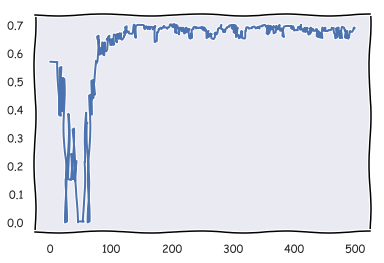

In [487]:
plt.plot(performance)

In [488]:
indices[-1]

[11, 107, 159, 505, 667, 722, 858]

## Linear Optimizer Solution

In [527]:
lp_problem = pulp.LpProblem("My LP Problem", pulp.LpMaximize)

X = []
for k in range(3):
    X.append(pulp.LpVariable('x'+str(k),cat='Continuous'))

# Objective
lp_problem += (3*X[0] + 8*X[1])

# Constraints
lp_problem += (X[0]-X[1]+2*X[2]<=3)
lp_problem += (X[0]-X[1]>=2)
lp_problem += (X[2]-X[1]-X[0]>=1)

In [528]:
lp_problem

My LP Problem:
MAXIMIZE
3*x0 + 8*x1 + 0
SUBJECT TO
_C1: x0 - x1 + 2 x2 <= 3

_C2: x0 - x1 >= 2

_C3: - x0 - x1 + x2 >= 1

VARIABLES
x0 free Continuous
x1 free Continuous
x2 free Continuous

In [529]:
lp_problem.solve()

1

In [530]:
pulp.LpStatus[lp_problem.status]

'Optimal'

In [534]:
for variable in lp_problem.variables():
    print("{} = {}".format(variable.name, variable.varValue))

print('\nOptimal Value = %f'%(pulp.value(lp_problem.objective)))

x0 = 0.75
x1 = -1.25
x2 = 0.5

Optimal Value = -7.750000
